<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 5:  Web Scraping
### Finding Underpriced RVs on Craigslist

![](https://snag.gy/WrdUMx.jpg)

In this project we will be practicing our web scraping skills.  You can use Scrapy or Python requests in order to complete this project.  It may be helpful to write some prototype code in this notebook to test your assumptions, then move it into a Python file that can be run from the command line.

> In order to run code from the command line, instead of the notebook, you just need to save your code to a file (with a .py extension), and run it using the Python interpreter:<br><br>
> `python my_file.py`

You will be building a process to scrape a single category of search results on Craigslist, that can easily be applied to other categories by changing the search terms.  The main goal is to be able to target and scrape a single page given a set of parameters.

**If you use Scrapy, provide your code in a folder.**

## Import your libraries for scrapy / requests / pandas / numpy / etc
Setup whichever libraries you need. Review past material for reference.

In [204]:
# PREPARE REQUIRED LIBRARIES
import pandas as pd
import numpy as np
import seaborn as sns
import re
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score, StratifiedKFold
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
import requests
from scrapy.selector import Selector

from matplotlib import pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1.  Scrape for the largest US cities (non-exhaustive list)
Search, research, and scrape Wikipedia for a list of the largest US cities.  There are a few sources but find one that is in a nice table.  We don't want all cities, just signifficant cities.  Examine your source.  Look for what can be differentiable.

- Use requests
- Build XPath query(ies)
- Extract to a list
- Clean your list

In [205]:
# SCRAPE WIKIPEDIA FOR LARGEST US CITIES (NON-EXHAUSTIVE LIST)
response = requests.get("https://simple.wikipedia.org/wiki/List_of_United_States_cities_by_population")
HTML = response.text  
HTML[0:100]

u'<!DOCTYPE html>\n<html class="client-nojs" lang="en" dir="ltr">\n<head>\n<meta charset="UTF-8"/>\n<title'

In [206]:
city_state = Selector(text=HTML).xpath("//td/a/text()").extract()

In [207]:
city_state = city_state[:100]

In [208]:
city = []
state = []
for i in range(len(city_state)):
    if i%2 == 0:
        city.append(city_state[i])
    else:
        state.append(city_state[i])

In [209]:
#<td align="right">
population = Selector(text=HTML).xpath("//td[@align='right']/text()").extract()

In [210]:
population = population[:50]

In [211]:
whole = dict(City = city, State = state, Population = population)

In [212]:
top = pd.DataFrame(data=whole)

In [213]:
top['Population'] = top['Population'].apply(lambda x: x.replace(',', ''))

In [214]:
top['City'].values

array([u'New York', u'Los Angeles', u'Chicago', u'Houston',
       u'Philadelphia', u'Phoenix', u'San Antonio', u'San Diego',
       u'Dallas', u'San Jose', u'Austin', u'Jacksonville',
       u'San Francisco', u'Indianapolis', u'Columbus', u'Fort Worth',
       u'Charlotte', u'Detroit', u'El Paso', u'Seattle', u'Denver',
       u'Washington', u'Memphis', u'Boston', u'Nashville', u'Baltimore',
       u'Oklahoma City', u'Portland', u'Las Vegas', u'Louisville',
       u'Milwaukee', u'Albuquerque', u'Tucson', u'Fresno', u'Sacramento',
       u'Long Beach', u'Kansas City', u'Mesa', u'Atlanta',
       u'Virginia Beach', u'Omaha', u'Colorado Springs', u'Raleigh',
       u'Miami', u'Oakland', u'Minneapolis', u'Tulsa', u'Cleveland',
       u'Wichita', u'New Orleans'], dtype=object)

<img src="http://imgur.com/xDpSobf.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1.2 Only retain cities with properly formed ASCII

Optionally, filter out any cities with impropper ASCII characters.  A smaller list will be easier to look at.  However you may not need to filter these if you spend more time scraping a more concise city list.  This list should help you narrow down the list of regional Craigslist sites.

In [215]:
# ONLY RETAIN PROPERLY FORMED CITIES WITH FILTERING FUNCTION


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2.  Write a function to capture current pricing information via Craigslist in one city.
Choose a city from your scraped data, then go to the cooresponding city section on Craigslist, searching for "rv" in the auto section.  Write a method that pulls out the prices.

In [216]:
sf_response = requests.get('http://sfbay.craigslist.org/search/sss?query=rv')

#http://sfbay.craigslist.org/search/sss?query=rv

In [217]:
sf_crag = sf_response.text

In [218]:
price = Selector(text=sf_crag).xpath("//span/span[@class='price']/text()").extract()

In [219]:
price[:5]

[u'$17999', u'$13999', u'$9999', u'$9999', u'$17999']

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2.1 Create a mapping of cities to cooresponding regional Craigslist URLs

Major US cities on Craigslist typically have their own cooresponding section (ie: SFBay Area, NYC, Boston, Miami, Seattle, etc).  Later, you will use these to query search results for various metropolitian regions listed on Craigslist.  Between the major metropolitan Craigslist sites, the only thing that will differ is the URL's that correspond to them.

The point of the "mapping":  Create a data structure that allows you to iterate with both the name of the city from Wikipedia, with the cooresponding variable that that will allow you to construct each craigslist URL for each region.

> For San Francsico (the Bay Area metropolitan area), the url for the RV search result is:
> http://sfbay.craigslist.org/search/sss?query=rv
>
> The convention is http://[region].craigslist.org/search/sss?query=rf
> Replacing [region] with the cooresponding city name will allow you to quickly iterate through each regional Craigslist site, and scrape the prices from the search results.  Keep this in mind while you build this "mapping".


In [220]:
top['crag'] = top['City'].apply(lambda x: x.replace(' ', '').lower())

In [221]:
#change san francisco and san jose to sfbay
top.loc[12,'crag'] = 'sfbay'
top.loc[9, 'crag'] = 'sfbay'

In [222]:
top.head()

,City,Population,State,crag
0,New York,8491079,New York,newyork
1,Los Angeles,3928864,California,losangeles
2,Chicago,2722389,Illinois,chicago
3,Houston,2239558,Texas,houston
4,Philadelphia,1560297,Pennsylvania,philadelphia


In [223]:
top['crag'].values

array([u'newyork', u'losangeles', u'chicago', u'houston', u'philadelphia',
       u'phoenix', u'sanantonio', u'sandiego', u'dallas', 'sfbay',
       u'austin', u'jacksonville', 'sfbay', u'indianapolis', u'columbus',
       u'fortworth', u'charlotte', u'detroit', u'elpaso', u'seattle',
       u'denver', u'washington', u'memphis', u'boston', u'nashville',
       u'baltimore', u'oklahomacity', u'portland', u'lasvegas',
       u'louisville', u'milwaukee', u'albuquerque', u'tucson', u'fresno',
       u'sacramento', u'longbeach', u'kansascity', u'mesa', u'atlanta',
       u'virginiabeach', u'omaha', u'coloradosprings', u'raleigh',
       u'miami', u'oakland', u'minneapolis', u'tulsa', u'cleveland',
       u'wichita', u'neworleans'], dtype=object)

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. Define a function to caculate mean and median price per city.

Now that you've created a list of cities you want to scrape, adapt your solution for grabbing data in one region site, to grab data for all regional sites that you collected, then calculate the mean and median price of RV results from each city.

> Look at the URLs from a few different regions (ie: portland, phoenix, sfbay), and find what they have in common.  Determine the area in the URL string that needs to change the least, and figure out how to replace only that portion of the URL in order to iterate through each city.

In [226]:
#see below

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 4. Run your scraping process, and save your results to a CSV file.

In [361]:
rv = pd.read_csv('crag/whole.csv')

In [362]:
rv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51103 entries, 0 to 51102
Data columns (total 2 columns):
rv_city     51103 non-null object
rv_price    51103 non-null object
dtypes: object(2)
memory usage: 798.6+ KB


In [363]:
rv['rv_price'] = rv['rv_price'].map(lambda x: x.strip('$'))
rv['rv_price'] = pd.to_numeric(rv['rv_price'])

In [364]:
rv['rv_city'] = rv['rv_city'].map(lambda x: x.replace(' ','').replace(',', '').lower())

In [365]:
rv.head()

,rv_city,rv_price
0,houston,21987
1,houston,6500
2,houston,3200
3,houston,37900
4,houston,49995


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 5. Do an analysis of the RV market.

Go head we'll wait.  Anything notable about the data?

In [367]:
rv_group = rv.groupby('rv_city')[['rv_price']].mean().add_prefix('avrg_').round(2).reset_index()

In [368]:
rv_group['median_rv_price'] = rv.groupby('rv_city')['rv_price'].apply(np.median).values

In [369]:
rv_group.head()

,rv_city,avrg_rv_price,median_rv_price
0,albuquerque,33830.62,15899.0
1,atlanta,17907.47,11466.0
2,austin,27600.53,14600.0
3,baltimore,12742.45,3271.5
4,boston,14153.42,5097.5


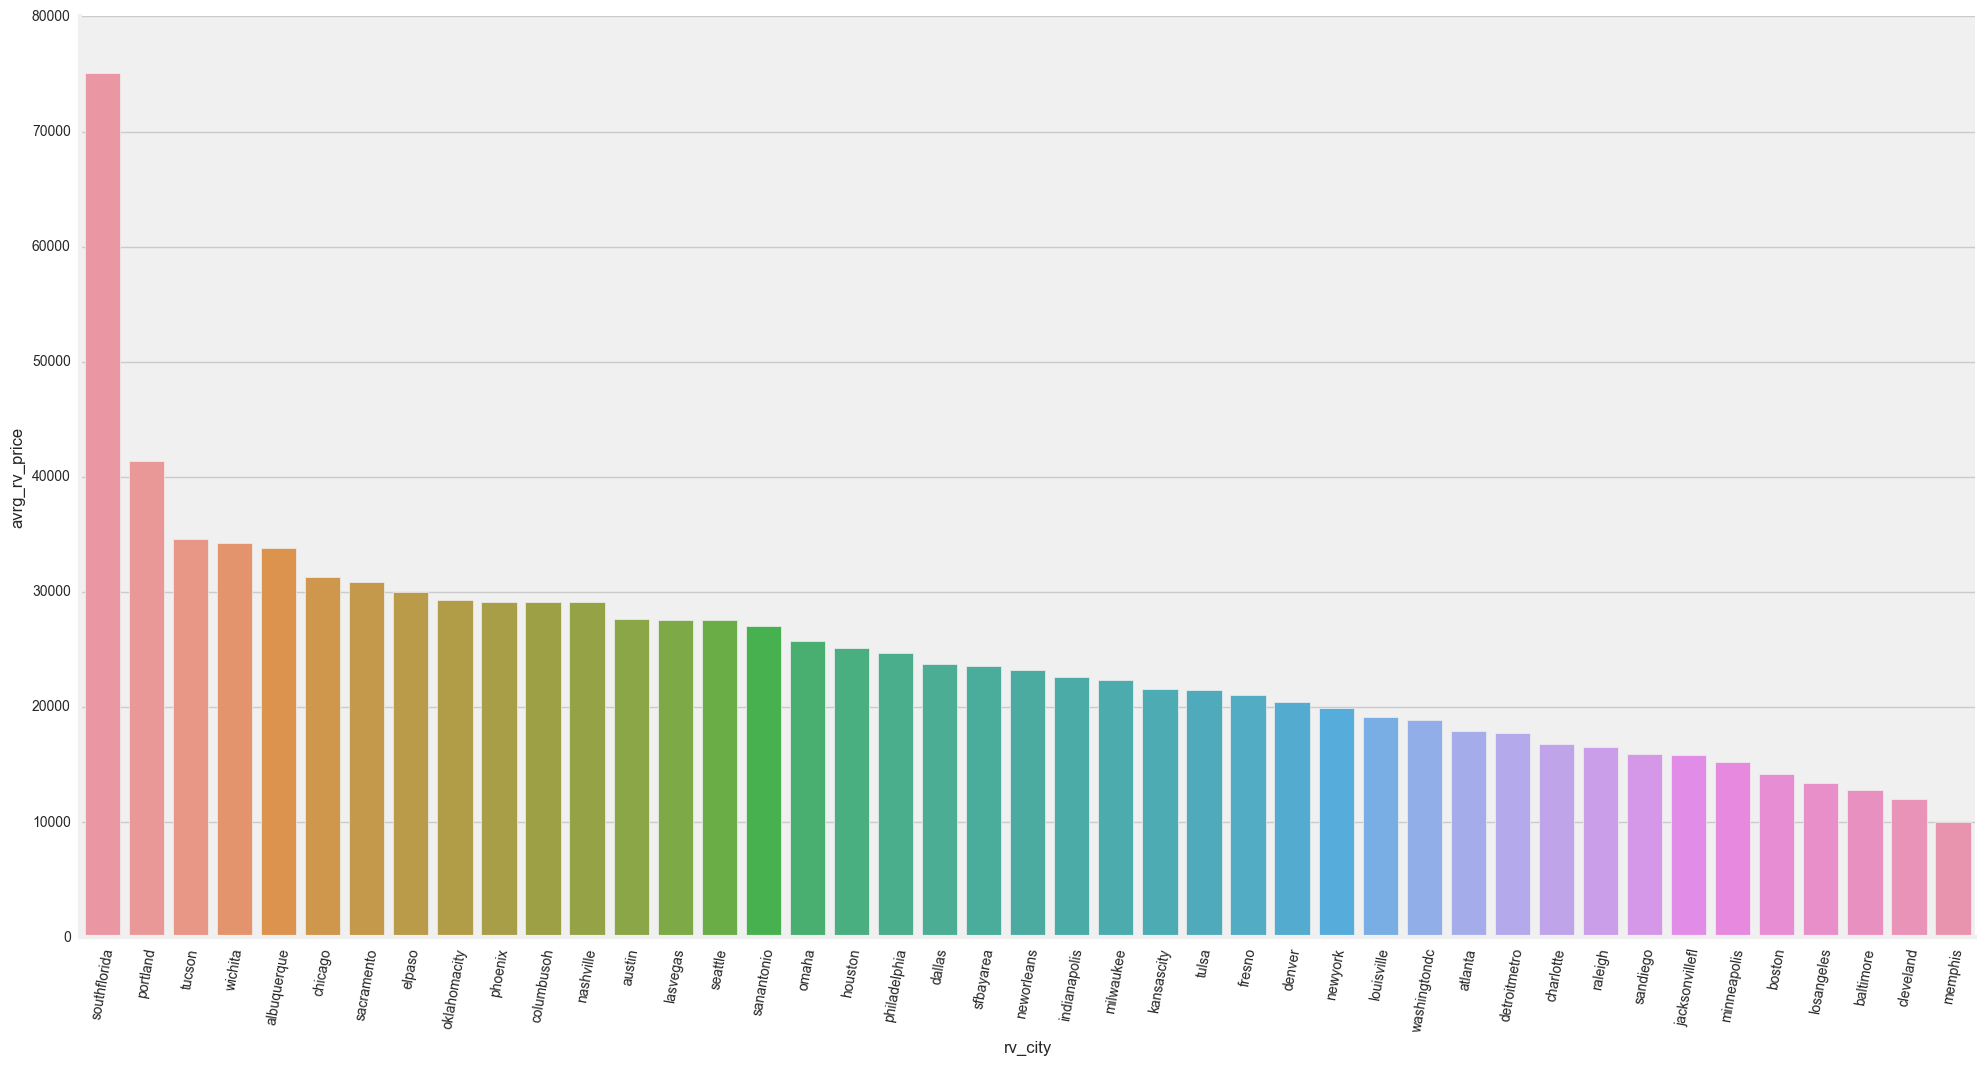

In [370]:
#this is by average rv price
sns.factorplot(data=rv_group.sort_values(by='avrg_rv_price',ascending=False), x='rv_city', y='avrg_rv_price', kind='bar', size=10, aspect=2).set_xticklabels(rotation=80)

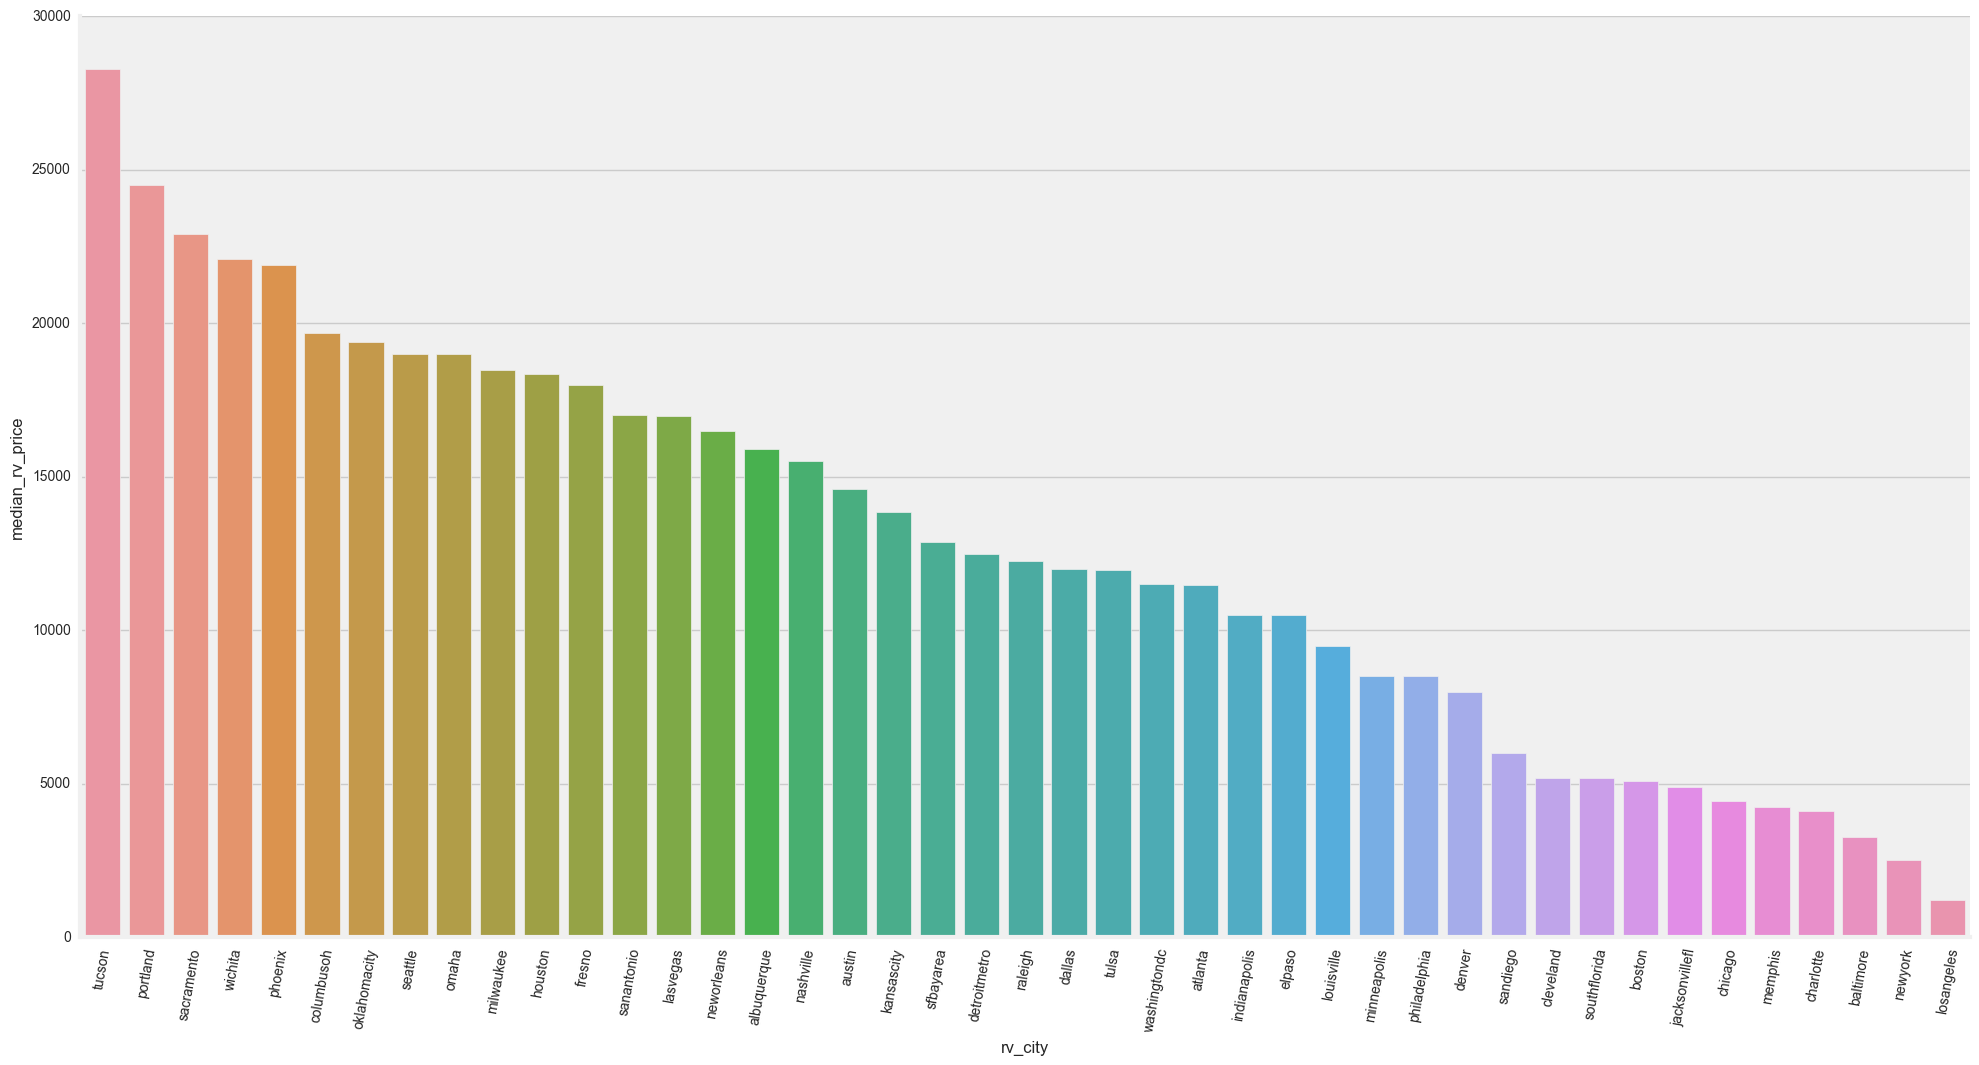

In [372]:
sns.factorplot(data=rv_group.sort_values(by='median_rv_price',ascending=False), x='rv_city', y='median_rv_price', kind='bar', size=10, aspect=2).set_xticklabels(rotation=80)

Conclusion: median price is better at reflecting the rv listing price in each region.

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 5.1 Does it makes sense to buy RVs in one region and sell them in another?

Assuming the cost of shipping or driving from one regional market to another.

In [373]:
#There are a lot of non-rv listings. Try to get rid of them (outliers)
small_number = rv[rv['rv_price'] < 1000]
outlier = rv[rv['rv_price'] > 50000]
print small_number.shape, outlier.shape

(10910, 2) (6189, 2)


In [375]:
rv = rv[(rv['rv_price'] > 1000) & (rv['rv_price'] < 50000)]
rv.describe()

,rv_price
count,33781.000000
mean,18334.276724
std,12960.428180
min,1025.000000
25%,6695.000000
50%,16900.000000
75%,26514.000000
max,49999.000000


In [376]:
rv[rv['rv_city'] == 'sfbayarea'].max()

rv_city     sfbayarea
rv_price        49999
dtype: object

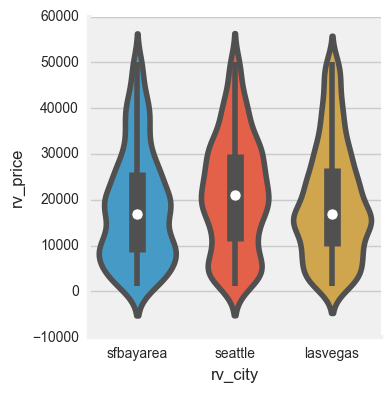

In [382]:
sns.factorplot(data=rv[(rv['rv_city'] == 'sfbayarea') | (rv['rv_city'] == 'seattle')|(rv['rv_city'] == 'lasvegas')], x='rv_city', y='rv_price', kind='violin', size=4, aspect=1)

<img src="http://imgur.com/xDpSobf.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 5.2 Can you pull out the "make" from the markup and include that in your analyis?
How reliable is this data and does it make sense?

In [ ]:
#blocked by craiglist

<img src="http://imgur.com/xDpSobf.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 5.3 Are there any other variables you could pull out of the markup to help describe your dataset?

In [ ]:
#blocked by craiglist

<img src="http://imgur.com/xDpSobf.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 6. Move your project into scrapy (if you haven't used Scrapy yet)

>Start a project by using the command `scrapy startproject [projectname]`
> - Update your settings.py (review our past example)
> - Update your items.py
> - Create a spiders file in your `[project_name]/[project_name]/spiders` directory

You can update your spider class with the complete list of craigslist "start urls" to effectively scrape all of the regions.  Start with one to test.

Updating your parse method with the method you chose should require minimal changes.  It will require you to update your parse method to use the response parameter, and an item model (defined in items.py).

In [ ]:
#the project is already done in scrapy

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 7.  Chose another area of Craigslist to scrape.

**Choose an area having more than a single page of results, then scrape multiple regions, multiple pages of search results and or details pages.**

This is the true exercise of being able to understand how to succesffuly plan, develop, and employ a broader scraping strategy.  Even though this seems like a challenging task, a few tweeks of your current code can make this very managable if you've pieced together all the touch points.  If you are still confused as to some of the milestones within this process, this is an excellent opportunity to round out your understanding, or help you build a list of questions to fill in your gaps.

_Use Scrapy!  Provide your code in this project directory when you submit this project._

## Optional: Interview Questions

---- 

### SQL Practice

1)
We have a deliveries table with 3000 rows

`SELECT * FROM deliveries; 
-- 3000 rows in set (0.05 sec) `

15 of those orders are from a customer with the customer_id_number=32

`SELECT * FROM deliveries WHERE customer_id_number = 32;
-- 15 rows in set (0.10 sec)`

Yet, when we SELECT the number of orders that are not from customer_id_number = 32, we only get 2960 results:

`SELECT * FROM deliveries WHERE customer_id_number <> 32;
-- 2960 rows in set (0.11 sec)`

**Question: What’s wrong? And why might this be the case? Modify your code to fix this. **

2) Construct the following tables:

`mysql> SELECT * FROM Employee;
+--------+----------+--------+
| emp_id | emp_name | salary |
+--------+----------+--------+
| 1      | James    |   2000 |
| 2      | Jack     |   4000 |
| 3      | Henry    |   6000 |
| 4      | Tom      |   8000 |
+--------+----------+--------+
4 rows IN SET (0.00 sec)`


`mysql> SELECT * FROM Department;
+---------+-----------+
| dept_id | dept_name |
+---------+-----------+
| 101     | Sales     |
| 102     | Marketing |
| 103     | Finance   |
| 104     | Accounting   |
+---------+-----------+
3 rows IN SET (0.00 sec)`


`mysql> SELECT * FROM Register;
+--------+---------+
| emp_id | dept_id |
+--------+---------+
|      1 |     101 |
|      2 |     102 |
|      3 |     103 |
|      4 |     102 |
+--------+---------+
4 rows IN SET (0.00 sec)`

** Questions: ** 
- Which employees belong to which department? Show this using one line of code (hint: more than one join) 
- What is the total marketing salary? 
- Using a join, can you show that there are no employees in accounting? 



3) Given an Employee table which has 3 fields – Id (Primary key), Salary and Manager Id, where manager id is the id of the employee that manages the current employee, find all employees that make more than their manager in terms of salary. Create the table and write the code that finds this


--- 
### Predictive Modeling

- What are some differences you would expect in a regression model that minimizes squared error, versus a model that minimizes absolute error? In which cases would each error  metric be appropriate?

mse: sensitive to outliers
mae: fitting more to the median and you want to minimize the effect of outliers to your results


- What error metric would you use to evaluate how good a binary classifier is? What if the classes are imbalanced?  What if there are more than 2 groups?

- What are various ways to predict a binary response variable? Can you compare two of them and tell me when one would be more appropriate? What’s the difference logistic regression and SVMs? 

- What is the difference between the loss functions used by SVMs and Logistic Regression? 

- What is R-squared? What are some other metrics that could be better than R-squared and why?

- You run your regression on different subsets of your data, and find that in each subset, the beta value for a certain variable varies wildly. What could be the issue here?


--- 
### Coding Questions 

- Given a sorted array and a number x, find a pair in array whose sum is closest to x. What is the time complexity of your algorithm? 
    
    `Examples:`
        Input: arr[] = {10, 22, 28, 29, 30, 40}, x = 54
        Output: 22 and 30

        Input: arr[] = {1, 3, 4, 7, 10}, x = 15
        Output: 4 and 10
        
- Check out this video on Linear Time Algorithm for finding the median: https://www.youtube.com/watch?v=_xntajCBLoE. Implement your version of this algorithm in Python. 

- Search in an almost sorted array: Given an array which is sorted, but after sorting some elements are moved to either of the adjacent positions, i.e., arr[i] may be present at arr[i+1] or arr[i-1]. Write an efficient function to search an element in this array. Basically the element arr[i] can only be swapped with either arr[i+1] or arr[i-1]. For example consider the array {2, 3, 10, 4, 40}, 4 is moved to next position and 10 is moved to previous position. [Hint: You can do this O(log n) time complexity]

    `Examples: `
        Input: arr[] =  {10, 3, 40, 20, 50, 80, 70}, key = 40
        Output: 2 
        Output is index of 40 in given array

        Input: arr[] =  {10, 3, 40, 20, 50, 80, 70}, key = 90
        Output: -1
        -1 is returned to indicate element is not present